# Inverting Amplifier

## Import and Formatting

The goal of this section is to import all the necessary files and libraries required for the subsequent data analysis.  
It also includes setting up the formatting parameters for the plots and visualizations.

### Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool, cpu_count
from PySpice.Spice.Netlist import (
    Circuit, SubCircuitFactory
)
from PySpice.Unit import *
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary

### Formatting

Adjusting Plotly chart settings for clarity and consistency.

In [2]:
# ----  Formatting charts
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['axes.edgecolor']  = "#bcbcbc"
mpl.rcParams['patch.linewidth'] = 0.5
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['axes.facecolor']  = "#eeeeee"
mpl.rcParams['axes.labelsize']  = "large"
mpl.rcParams['axes.grid']       = True
mpl.rcParams['grid.linestyle']  = "--"
mpl.rcParams['patch.edgecolor'] = "#eeeeee"
mpl.rcParams['axes.titlesize']  = "x-large"

## Circuit

On the [](#Aopinverting), you can see the circuit that will be studied.  
It is a relatively simple configuration, consisting of an operational amplifier (op-amp), its two bias connections, and two resistors labeled **$R_1$** and **$R_2$**.

The objective is to fully understand how this circuit operates starting from its governing equations and then moving on to simulations to explore its limitations.

```{figure} ./images/Aopinverting.svg
:name: Aopinverting
:align: center
:width: 500px
Inverting amplifier circuit
````

## Equation

The equation [](#equation_aop_inversing) is straightforward.
It shows that the gain depends on the ratio $\frac{R_2}{R_1}$ between the two resistors.
The negative sign ($-$) indicates that the output signal is **inverted** relative to the input.


```{math}
:label: equation_aop_inversing
V_{out} = - V_{in} \cdot \frac{R_2}{R_1}
```

## Demonstration

Consider the **classic inverting amplifier** configuration:

* The input voltage $V_{in}$ is applied through resistor $R_1$ to the **inverting input** $(-)$.
* The **non-inverting input** $(+)$ is connected to ground $(0~\text{V})$.
* The **feedback resistor** $R_2$ connects the **output** $V_{out}$ to the inverting input.

```{figure} ./images/Aopinverting_demonstration.svg
:name: Aopinverting_demonstration
:align: center
:width: 500px
Inverting amplifier circuit used for demonstration
```

### Step 1 Virtual short principle

Under the **ideal linear regime** (ideal op-amp assumption):

$$V^+ = V^-$$

Since the non-inverting input is grounded:

$$V^+ = 0 \quad \Rightarrow \quad V^- = 0$$

### Step 2 Applying Kirchhoff’s voltage law (KVL)

From the circuit:

$$
\begin{cases}
V_{in} = U_{R_1} \\
V_{out} = -U_{R_2}
\end{cases}
$$

> The voltage across $R_1$ corresponds to the input voltage,
> while the feedback resistor $R_2$ experiences the output voltage with opposite polarity.

### Step 3 Ohm’s law and input current assumption

Using **Ohm’s law** $U = R \cdot i$, and assuming **infinite input impedance**,
the current entering the op-amp is negligible:

$$i_{in} = 0$$

Therefore, the same current flows through both resistors $R_1$ and $R_2$:

$$
\begin{cases}
V_{in} = R_1 \cdot i \\
V_{out} = -R_2 \cdot i
\end{cases}
$$

> The current $i$ is identical in both resistors since the op-amp draws no current.

### Step 4 Solving for the output voltage

From the first equation:

$$i = \dfrac{V_{in}}{R_1}$$

Substitute into the second:

$$V_{out} = -R_2 \cdot \dfrac{V_{in}}{R_1}$$

> Substituting $i$ gives the proportional relationship between output and input voltages.

### Final Expression

$$\boxed{V_{out} = - V_{in} \cdot \dfrac{R_2}{R_1}}$$

> This is the fundamental **gain equation** of an inverting amplifier.
> The output is inverted and scaled by the ratio $\dfrac{R_2}{R_1}$.

**Notes:**

* The negative sign means the output is **180° out of phase** with the input.
* In real op-amps, nonzero input bias currents and finite gain cause small deviations that can be analyzed using Kirchhoff’s current law.

## Circuit Construction

```{figure} ./images/Aopinverting_pyspace.svg
:name: Aopinverting_montage
:align: center
:width: 500px
Inverting amplifier circuit setup for SPICE simulation
````

In the [](#Aopinverting_montage) figure, you can observe the complete circuit layout and the accessible nodes.

First, the circuit includes an **input** and an **output**, labeled `input` and `out`, respectively.
These are the terminals where the input signal is applied and the output signal is measured.

Next, the op-amp power supplies are labeled `VCC` and `VEE`.
Be careful to maintain the correct polarity: `VCC` must be greater than `VEE`.

Finally, there is an intermediate node `v-`, which can be used either to connect additional components or to monitor the circuit’s behavior depending on the analysis being performed.

In [3]:
class AOP_montage(SubCircuitFactory):
    NAME = 'AOP_inverting_amplifier'
    NODES = ('input', 'v-', 'out', 'VCC', 'VEE')

    def __init__(self, R1=10@u_kOhm, R2=100@u_kOhm):
        super().__init__()
        # AOP 741 
        self.X('U1', 'UA741', self.gnd, 'v-', 'VCC', 'VEE', 'out')
        
        # Resistance contrôle
        self.R(1, 'input', 'v-', R1)
        self.R(2, 'v-', 'out', R2)
        
        # Resistance de charge
        self.R('L', 'out', self.gnd, 10@u_kOhm)

## Simulation

### Static Simulation

In a **static simulation** (or **operating point analysis**), we study the **steady-state voltages and currents**.
For example, if an input voltage ( $V_{in}$ ) is applied, the operating point of the output ( $V_{out}$ ) is given by:

$$V_{out} = - V_{in} \cdot \frac{R_2}{R_1}$$

These values can be retrieved from the **operating point analysis**:

$$V_{in} = V^+ = V^- \quad ; \quad V_{out} = \text{voltage at the output node}$$

In [4]:
circuit = Circuit('Inverting op-amp Amplifier')
circuit.include('lib/UA741.sub')

# Alimentation AOP
circuit.V('input', 'input', circuit.gnd, 1@u_V)
circuit.V('cc', 'VCC', circuit.gnd, 15@u_V)
circuit.V('ee', 'VEE', circuit.gnd, -15@u_V)

circuit.subcircuit(AOP_montage())
circuit.X('AMP1', 'AOP_inverting_amplifier', 'input', 'v-', 'out', 'VCC', 'VEE')

.title Inverting op-amp Amplifier
.include C:\Users\sacha\Desktop\Python\Electronique\electronique_book\AOP\lib\UA741.sub
.subckt AOP_inverting_amplifier input v- out VCC VEE
XU1 0 v- VCC VEE out UA741
R1 input v- 10kOhm
R2 v- out 100kOhm
RL out 0 10kOhm
.ends AOP_inverting_amplifier
Vinput input 0 1V
Vcc VCC 0 15V
Vee VEE 0 -15V
XAMP1 input v- out VCC VEE AOP_inverting_amplifier



In [5]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis  = simulator.operating_point()

# ---- print all the node
#for node in analysis.nodes.values():
#    print(f'Node {str(node)} : {float(node[0]):4.1f} V')

print("Characteristic circuit")
print("----------------------")
print(f"Input value  : Vin  = {float(analysis.nodes['input'][0]):.1f} V")
print(f"Output value : Vout = {float(analysis.nodes['out'][0]):.1f} V")
print(f"Gain :         A    = {float(analysis.nodes['out'][0])/ float(analysis.nodes['input'][0]) :.1f}")

Characteristic circuit
----------------------
Input value  : Vin  = 1.0 V
Output value : Vout = -10.0 V
Gain :         A    = -10.0


### Gain Analysis

We can first verify that the amplifier gain matches the expected value.  
From the resistors used, we have:

$$
\frac{R_2}{R_1} = \frac{100}{10} = 10
$$

> The output magnitude therefore corresponds exactly to the expected gain as given by the fundamental equation [](#equation_aop_inversing).

Additionally, the output is **negative**, which is consistent with the **inverting amplifier** configuration.


### Dynamic Simulation

The **dynamic simulation** (transient analysis) allows us to observe the **time-domain response** of the circuit when the input signal varies over time.  
For example, consider a sinusoidal input:

$$V_{in}(t) = V_0 \cdot \sin(2 \pi f t)$$

The ideal output is then given by:

$$
V_{out}(t) = A_v \cdot V_{in}(t) = \left(-\frac{R_2}{R_1}\right) V_0 \cdot \sin(2 \pi f t)
$$

where $A_v$ is the **voltage gain** as defined in [](#equation_aop_inversing).

In [6]:
circuit = Circuit('Inverting op-amp Amplifier')
circuit.include('lib/UA741.sub')

# Alimentation AOP
circuit.SinusoidalVoltageSource('input', 'input', circuit.gnd, amplitude=1@u_V, frequency=1@u_kHz)
circuit.V('cc', 'VCC', circuit.gnd, 15@u_V)
circuit.V('ee', 'VEE', circuit.gnd, -15@u_V)

circuit.subcircuit(AOP_montage())
circuit.X('AMP1', 'AOP_inverting_amplifier', 'input', 'v-', 'out', 'VCC', 'VEE')

.title Inverting op-amp Amplifier
.include C:\Users\sacha\Desktop\Python\Electronique\electronique_book\AOP\lib\UA741.sub
.subckt AOP_inverting_amplifier input v- out VCC VEE
XU1 0 v- VCC VEE out UA741
R1 input v- 10kOhm
R2 v- out 100kOhm
RL out 0 10kOhm
.ends AOP_inverting_amplifier
Vinput input 0 DC 0V AC 1V SIN(0V 1V 1kHz 0s 0Hz)
Vcc VCC 0 15V
Vee VEE 0 -15V
XAMP1 input v- out VCC VEE AOP_inverting_amplifier



In [7]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=10@u_us, end_time=5@u_ms)

In [8]:
time = np.array(analysis.time)
vin = np.array(analysis['input'])
vout = np.array(analysis['out'])

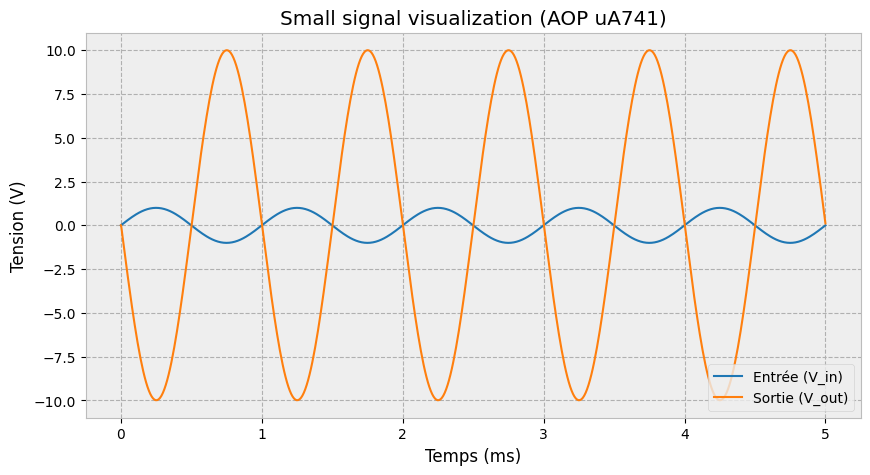

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(time*1000, vin, label='Entrée (V_in)', linewidth=1.5)
plt.plot(time*1000, vout, label='Sortie (V_out)', linewidth=1.5)
plt.title('Small signal visualization (AOP uA741)')
plt.xlabel('Temps (ms)')
plt.ylabel('Tension (V)')
plt.legend()
plt.show()

### Signal Analysis

In the graph, the **blue line** represents the input signal to the amplifier,  
while the **orange line** corresponds to the output signal.

We can clearly observe that the gain is $10$:  
the input signal reaches a maximum of $1~\text{V}$, while the output reaches $10~\text{V}$.

The output signal is also **phase-shifted by 180°**, indicating a negative gain.  
This is characteristic of an **inverting amplifier**, where a positive input produces a negative output.

For instance, when the input voltage is $+1~\text{V}$, the output voltage is $-10~\text{V}$, as illustrated in the graph.

### Saturation Simulation

When the input signal amplitude is too high, the output may **reach the supply voltage limits** ($+V_{CC}$ and $-V_{SS}$).  
In this case, the output waveform is **no longer a perfect sine wave**:

$$
V_{out}(t) =
\begin{cases}
+V_{CC} & \text{if } V_{out,ideal} > +V_{CC} \\
-V_{SS} & \text{if } V_{out,ideal} < -V_{SS} \\
V_{out,ideal} & \text{otherwise}
\end{cases}
$$

This limitation arises because the **op-amp cannot output a voltage higher than** $+V_{CC}$ **or lower than** $-V_{SS}$.

In [10]:
# Initialisation variable
amplitude = 1.7

circuit = Circuit('Inverting op-amp Amplifier')
circuit.include('lib/UA741.sub')

# Alimentation AOP
circuit.SinusoidalVoltageSource('input', 'input', circuit.gnd, amplitude=amplitude@u_V, frequency=1@u_kHz)
circuit.V('cc', 'VCC', circuit.gnd, 15@u_V)
circuit.V('ee', 'VEE', circuit.gnd, -15@u_V)

circuit.subcircuit(AOP_montage())
circuit.X('AMP1', 'AOP_inverting_amplifier', 'input', 'v-', 'out', 'VCC', 'VEE')

.title Inverting op-amp Amplifier
.include C:\Users\sacha\Desktop\Python\Electronique\electronique_book\AOP\lib\UA741.sub
.subckt AOP_inverting_amplifier input v- out VCC VEE
XU1 0 v- VCC VEE out UA741
R1 input v- 10kOhm
R2 v- out 100kOhm
RL out 0 10kOhm
.ends AOP_inverting_amplifier
Vinput input 0 DC 0V AC 1V SIN(0V 1.7V 1kHz 0s 0Hz)
Vcc VCC 0 15V
Vee VEE 0 -15V
XAMP1 input v- out VCC VEE AOP_inverting_amplifier



In [11]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=10@u_us, end_time=5@u_ms)

In [12]:
time = np.array(analysis.time)
vin = np.array(analysis['input'])
vout = np.array(analysis['out'])

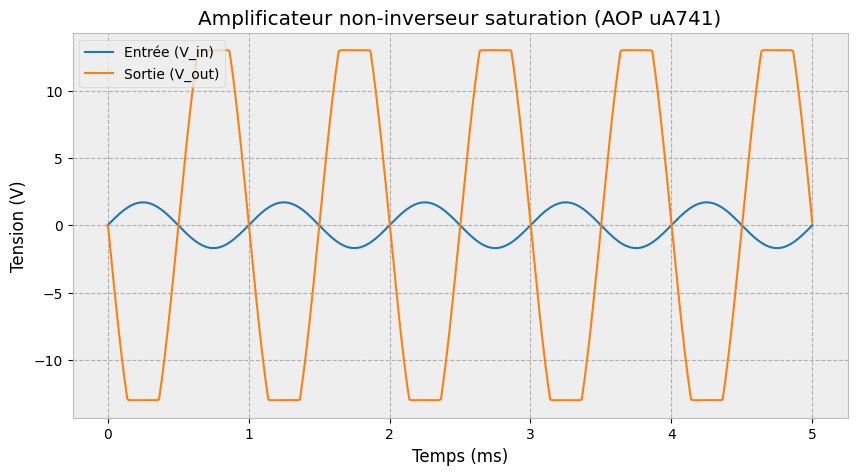

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(time*1000, vin, label='Entrée (V_in)', linewidth=1.5)
plt.plot(time*1000, vout, label='Sortie (V_out)', linewidth=1.5)
plt.title('Amplificateur non-inverseur saturation (AOP uA741)')
plt.xlabel('Temps (ms)')
plt.ylabel('Tension (V)')
plt.legend()
plt.show()

**Output Clipping**

The output signal can be seen to be **clipped**.  
This happens because the signal exceeds the amplifier's supply voltage limits, namely $+V_{CC}$ and $-V_{SS}$.

Since the amplifier cannot produce an output voltage beyond its power rails,  
the signal is limited (clipped) at these boundaries.

In other words, when the input drives the output above $+V_{CC}$ or below $-V_{SS}$,  
the amplifier **saturates**, and the waveform flattens at these voltage extremes.

## System Sensitivity

The goal of this section is to evaluate the **stability of the system**.  
This involves calculating the **sensitivity of the output** with respect to component variations, as well as observing how these variations depend on temperature.

### Theoretical Calculation

#### Sensitivity

- **With respect to R1**

$$
\frac{\partial V_{out}}{\partial R_1} = -\frac{\partial}{\partial R_1}\left(V_{in} \frac{R_2}{R_1}\right)
\quad \Rightarrow \quad
\frac{\partial V_{out}}{\partial R_1} = V_{in} \frac{R_2}{R_1^2} 
\quad \Rightarrow \quad
\frac{\partial V_{out}}{\partial R_1} = \frac{V_{out}}{R_1}
$$

- **With respect to R2**

$$
\frac{\partial V_{out}}{\partial R_2} = \frac{\partial}{\partial R_2}\left(V_{in} \frac{R_2}{R_1}\right)
\quad \Rightarrow \quad
\frac{\partial V_{out}}{\partial R_2} = \frac{V_{in}}{R_1} 
\quad \Rightarrow \quad
\frac{\partial V_{out}}{\partial R_2} = \frac{V_{out}}{R_2}
$$

#### Normalized Sensitivity

The **normalized sensitivity** is defined as:

$$
S_x^{norm} = \frac{x}{V_{out}} \frac{\partial V_{out}}{\partial x}
$$

- **For R1**

$$
S_{R_1}^{norm} = \frac{R_1}{V_{out}} \frac{\partial V_{out}}{\partial R_1} = -1
$$

- **For R2**

$$
S_{R_2}^{norm} = \frac{R_2}{V_{out}} \frac{\partial V_{out}}{\partial R_2} = 1
$$

**Interpretation:**

- $S_{R_1}^{norm} = -1$ : a **+1% change in R1** results in approximately a **-1% change in V_out**.  
- $S_{R_2}^{norm} = +1$ : a **+1% change in R2** results in approximately a **+1% change in V_out**.

---

## Uncertainty Calculation

### Combined Uncertainty

The combined output uncertainty due to resistor tolerances is given by:

$$
U = \sqrt{\left(\frac{\partial V_{out}}{\partial R_1} u_{R_1}\right)^2 + \left(\frac{\partial V_{out}}{\partial R_2} u_{R_2}\right)^2} 
\quad \Rightarrow \quad
U = \sqrt{\left(\frac{V_{out}}{R_1} u_{R_1}\right)^2 + \left(\frac{V_{out}}{R_2} u_{R_2}\right)^2} 
\quad \Rightarrow \quad
U = V_{out} \cdot \sqrt{\left(\frac{u_{R_1}}{R_1}\right)^2 + \left(\frac{u_{R_2}}{R_2}\right)^2}
$$


In [14]:
Vout = 10       # V
R1   = 10e3     # 10 kΩ
R2   = 100e3    # 100 kΩ
incertitude = 0.05  # 5%

u_R1 = R1 * incertitude / np.sqrt(3)
u_R2 = R2 * incertitude / np.sqrt(3)

U = Vout * np.sqrt((u_R1/R1)**2 + (u_R2/R2)**2)

```{note}
You may notice a factor of $\sqrt{3}$ appearing in the equations.  
This arises because the input parameters are assumed to follow a **uniform (rectangular) distribution**.  
When converting the standard deviation of a uniform distribution to an equivalent standard uncertainty, the factor $\sqrt{3}$ is **mandatory**.
```

In [15]:
print(f"Expanded uncertainty (95%) of the output voltage: {U:.3f} V")
print(f"Corresponding relative uncertainty: {U*2/Vout*100:.1f} %")

Expanded uncertainty (95%) of the output voltage: 0.408 V
Corresponding relative uncertainty: 8.2 %


### Monte-Carlo Uncertainty Analysis

The **Monte-Carlo method** is a statistical approach used to estimate the uncertainty of a system by simulating many possible scenarios.  
Instead of relying solely on analytical formulas, this method generates a large number of random samples for the input parameters (e.g., resistor values) based on their known tolerances or distributions.

For each sample set, the output voltage is calculated. After repeating this process many times, the distribution of output values provides an estimate of the **output uncertainty**, including possible non-linear effects and interactions between components.

This approach is particularly useful when:

- The system behavior is **non-linear**.
- Component variations are **not independent** or **not normally distributed**.
- A more **realistic assessment of uncertainty** is needed compared to purely analytical methods.

In practice, the Monte-Carlo simulation produces a **histogram of output values**, from which statistical quantities such as **mean, standard deviation, and confidence intervals** can be extracted.  

In [17]:
R1     = 10e3
R2     = 100e3
insert = 0.05
num    = int(1e3)
value  = np.zeros(num) 
amplitude = 1

for i in range(num): 
    circuit = Circuit('Inverting op-amp Amplifier')
    circuit.include('lib/UA741.sub')
    
    # Alimentation AOP
    circuit.V('input', 'input', circuit.gnd, amplitude@u_V)
    circuit.V('cc', 'VCC', circuit.gnd, 15@u_V)
    circuit.V('ee', 'VEE', circuit.gnd, -15@u_V)
    
    R1_result = np.random.uniform(R1 - R1*insert, R1 + R1*insert)
    R2_result = np.random.uniform(R2 - R2*insert, R2 + R2*insert)

    aop = AOP_montage(R1=R1_result@u_Ohm, R2=R2_result@u_Ohm)
    circuit.subcircuit(aop)
    circuit.X('AMP1', 'AOP_inverting_amplifier', 'input', 'v-', 'out', 'VCC', 'VEE')

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.operating_point()
    
    Vout = float(analysis['out'][0])
    value[i] = Vout

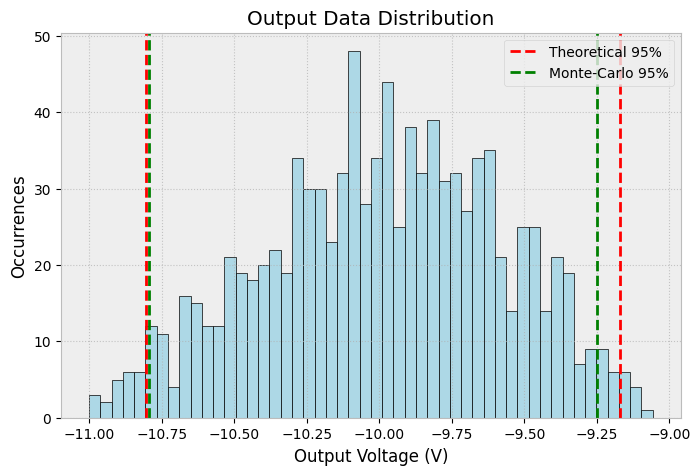

In [18]:
plt.figure(figsize=(8,5))
plt.title("Output Data Distribution")
plt.hist(value, bins=50, color='lightblue', edgecolor='black')
plt.xlabel("Output Voltage (V)")
plt.ylabel("Occurrences")

# Theoretical 95% confidence interval

plt.axvline(value.mean() + U*2, color="r", linestyle="--", label="Theoretical 95%")
plt.axvline(value.mean() - U*2, color="r", linestyle="--")


# Monte-Carlo 95% confidence interval
plt.axvline(np.percentile(value, 97.5), color="g", linestyle="--", label="Monte-Carlo 95%")
plt.axvline(np.percentile(value, 2.5), color="g", linestyle="--")

plt.legend()
plt.grid(True, linestyle=":", alpha=0.7)
plt.show()

**Shape of the Output Signal**

The output signal exhibits a **triangular shape**, rather than a Gaussian (normal) distribution.  
As a result, the usual broadening factor of **k = 2** no longer corresponds to 95% of the values, but to a different confidence level.

This effect can be clearly seen in the **Monte-Carlo estimated uncertainty**,  
which is significantly smaller than the value obtained using the **analytical method**.

In other words, because the output distribution is **non-Gaussian**,  
the standard **k = 2** rule for confidence intervals does **not apply directly**.

## Bode Diagram

### Visualization Issues

This section focuses on the **Bode plot** of the system.  
Sometimes, plotting may encounter **visualization problems**, such as improperly scaled axes, overlapping curves, or missing frequency points.  

It is important to ensure that:

- The frequency range is properly defined.
- Both magnitude and phase plots are clearly labeled.
- The plot is rendered with adequate resolution and grid lines for readability.

```{note} 
When using libraries like `matplotlib` or `control`, always check that logarithmic axes (`semilogx`) and frequency units are correctly set to avoid common display issues.
```

In [19]:
# Initialisation variable
amplitude = 1.7

circuit = Circuit('Inverting op-amp Amplifier')
circuit.include('lib/UA741.sub')

# Alimentation AOP
circuit.SinusoidalVoltageSource('input', 'input', circuit.gnd, amplitude=amplitude@u_V, frequency=100@u_MHz)
circuit.V('cc', 'VCC', circuit.gnd, 15@u_V)
circuit.V('ee', 'VEE', circuit.gnd, -15@u_V)

circuit.subcircuit(AOP_montage())
circuit.X('AMP1', 'AOP_inverting_amplifier', 'input', 'v-', 'out', 'VCC', 'VEE')

.title Inverting op-amp Amplifier
.include C:\Users\sacha\Desktop\Python\Electronique\electronique_book\AOP\lib\UA741.sub
.subckt AOP_inverting_amplifier input v- out VCC VEE
XU1 0 v- VCC VEE out UA741
R1 input v- 10kOhm
R2 v- out 100kOhm
RL out 0 10kOhm
.ends AOP_inverting_amplifier
Vinput input 0 DC 0V AC 1V SIN(0V 1.7V 100MegHz 0s 0Hz)
Vcc VCC 0 15V
Vee VEE 0 -15V
XAMP1 input v- out VCC VEE AOP_inverting_amplifier



In [20]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=100@u_ps, end_time=50@u_ns)

In [21]:
time = np.array(analysis.time)
vin = np.array(analysis['input'])
vout = np.array(analysis['out'])

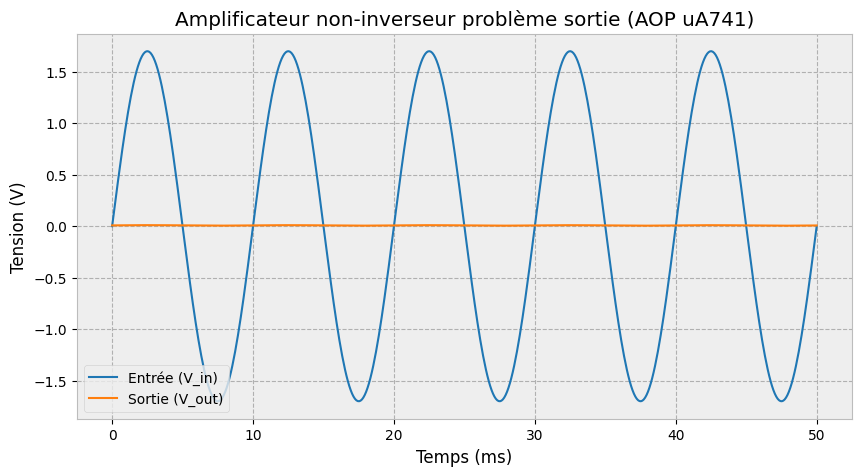

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(time*1e9, vin, label='Entrée (V_in)', linewidth=1.5)
plt.plot(time*1e9, vout, label='Sortie (V_out)', linewidth=1.5)
plt.title('Amplificateur non-inverseur problème sortie (AOP uA741)')
plt.xlabel('Temps (ms)')
plt.ylabel('Tension (V)')
plt.legend()
plt.show()

It can be observed that the output signal has **zero amplitude**.  
This occurs because the amplifier has a **limited bandwidth**.  

When the input frequency exceeds this bandwidth, the amplifier can no longer follow the signal accurately.  
As a result, the output amplitude is **severely attenuated** or even reduced to zero.

### Simulation

#### Method 1: Point-by-Point Simulation

In this approach, each point of the input signal is simulated **individually**.  
This allows precise observation of the system's response at specific input values, making it useful for:

- Understanding non-linear behavior.
- Capturing detailed effects at particular operating points.
- Comparing with analytical predictions for validation.

```{note}
While accurate, this method can be **computationally intensive** for large datasets or high-resolution signals.
```

In [23]:
import numpy as np

def phase_shift(signal_in, signal_out, freq, sampling_rate):
    """
    Compute the phase shift (in degrees) between two signals.

    Parameters
    ----------
    signal_in : array-like
        Input signal.
    signal_out : array-like
        Output signal.
    freq : float
        Frequency of the input signal (Hz).
    sampling_rate : float
        Sampling rate of the signals (samples per second).
    gain : float, optional
        Gain factor applied to the output signal (default is 1).

    Returns
    -------
    phase_deg : float
        Phase shift between input and output signals in degrees,
        normalized to the range [-180, +180].
    
    Notes
    -----
    The signals are first centered by subtracting their mean.
    The phase shift is computed using cross-correlation.
    """
    # Center the signals
    s1 = signal_in - np.mean(signal_in)
    s2 = signal_out - np.mean(signal_out)

    # Cross-correlation
    corr = np.correlate(s1, s2, mode='full')
    lag = np.argmax(corr) - len(s1) + 1

    # Time shift
    time_shift = lag / sampling_rate

    # Phase in degrees
    phase_deg = (time_shift * freq * 360) % 360
    if phase_deg > 180:
        phase_deg -= 360  # Normalize to [-180, +180]

    return phase_deg


In [24]:
# Initialisation variable
amplitude = 1.7

circuit = Circuit('Inverting op-amp Amplifier')
circuit.include('lib/UA741.sub')

# Alimentation AOP
circuit.SinusoidalVoltageSource('input', 'input', circuit.gnd, amplitude=amplitude@u_V, frequency=100@u_MHz)
circuit.V('cc', 'VCC', circuit.gnd, 15@u_V)
circuit.V('ee', 'VEE', circuit.gnd, -15@u_V)

circuit.subcircuit(AOP_montage())
circuit.X('AMP1', 'AOP_inverting_amplifier', 'input', 'v-', 'out', 'VCC', 'VEE')

.title Inverting op-amp Amplifier
.include C:\Users\sacha\Desktop\Python\Electronique\electronique_book\AOP\lib\UA741.sub
.subckt AOP_inverting_amplifier input v- out VCC VEE
XU1 0 v- VCC VEE out UA741
R1 input v- 10kOhm
R2 v- out 100kOhm
RL out 0 10kOhm
.ends AOP_inverting_amplifier
Vinput input 0 DC 0V AC 1V SIN(0V 1.7V 100MegHz 0s 0Hz)
Vcc VCC 0 15V
Vee VEE 0 -15V
XAMP1 input v- out VCC VEE AOP_inverting_amplifier



In [25]:
frequence = np.logspace(1, 8, 100)
gain = list()
phase     = list()
n_periods = 10
points_per_period = 100
epsilon = 1e-10


for i in frequence :
    # ---- initialisation parameter
    circuit.element("Vinput").frequency = i@u_Hz
    end_time = n_periods / i
    step_time = 1 / (i * points_per_period)

    # ---- simulation
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.transient(step_time=step_time@u_s, end_time=end_time@u_s)

    # ---- add parameter
    out = np.array(analysis['out'])
    inp = np.array(analysis['input'])

    ## Amplitude
    mid = len(out)//2
    gain_lineaire = abs(np.max(out[mid:])) / abs(np.max(inp[mid:])) + epsilon
    gain.append(20*np.log10(gain_lineaire))

    ## Phase 
    freq = i        # fréquence du signal
    dt = step_time  # ton pas temporel
    fs = 1 / dt     # fréquence d’échantillonnage
    
    phase.append(phase_shift(out[mid:], inp[mid:], freq, fs))
        
gain  = np.array(gain)
phase = np.array(phase)

#### Method 2 : Real & Imaginary

In [26]:
# Initialisation variable
amplitude = 1.7

circuit = Circuit('Inverting op-amp Amplifier')
circuit.include('lib/UA741.sub')

# Alimentation AOP
circuit.SinusoidalVoltageSource('input', 'input', circuit.gnd, amplitude=amplitude@u_V, frequency=1@u_Hz)
circuit.V('cc', 'VCC', circuit.gnd, 15@u_V)
circuit.V('ee', 'VEE', circuit.gnd, -15@u_V)

circuit.subcircuit(AOP_montage())
circuit.X('AMP1', 'AOP_inverting_amplifier', 'input', 'v-', 'out', 'VCC', 'VEE')

.title Inverting op-amp Amplifier
.include C:\Users\sacha\Desktop\Python\Electronique\electronique_book\AOP\lib\UA741.sub
.subckt AOP_inverting_amplifier input v- out VCC VEE
XU1 0 v- VCC VEE out UA741
R1 input v- 10kOhm
R2 v- out 100kOhm
RL out 0 10kOhm
.ends AOP_inverting_amplifier
Vinput input 0 DC 0V AC 1V SIN(0V 1.7V 1Hz 0s 0Hz)
Vcc VCC 0 15V
Vee VEE 0 -15V
XAMP1 input v- out VCC VEE AOP_inverting_amplifier



In [27]:
# Simulation AC
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.ac(start_frequency=10@u_Hz, stop_frequency=100@u_MHz, number_of_points=1000, variation='dec')

In [28]:
freq   = np.array(analysis.frequency)
gain2  = np.abs(np.array(analysis['out'])) / np.abs(np.array(analysis['input']))
phase2 = np.angle(np.array(analysis['out']), True) - np.angle(np.array(analysis['input']), True)

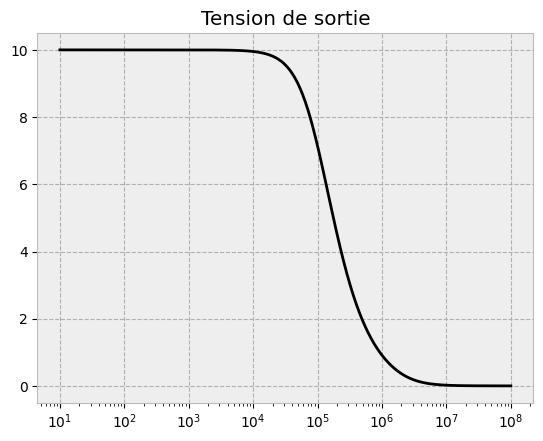

In [29]:
plt.figure()
plt.title("Tension de sortie")
plt.semilogx(freq, np.abs(analysis['out']), "black")
plt.show()

Donc nous pouvons voir que plus fréquences augmente, plus la tension de sortie baisse.

### Result

#### Result 1

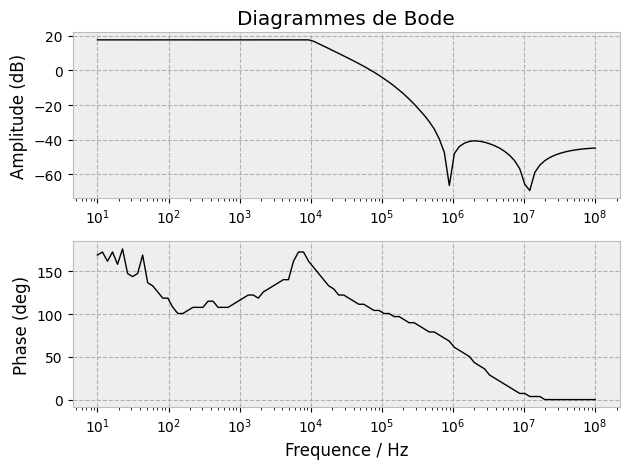

In [30]:
plt.subplot(211)
plt.title('Diagrammes de Bode')
plt.semilogx(frequence, gain, lw=1, c="black")    # Amplitude
plt.ylabel('Amplitude (dB)')


plt.subplot(212)
plt.semilogx(frequence, np.abs(phase), c="black", lw=1)  # Phase
plt.xlabel('Frequence / Hz')
plt.ylabel('Phase (deg)')


plt.tight_layout()  # Ajuster le placement des courbes
plt.show()

#### Result 2

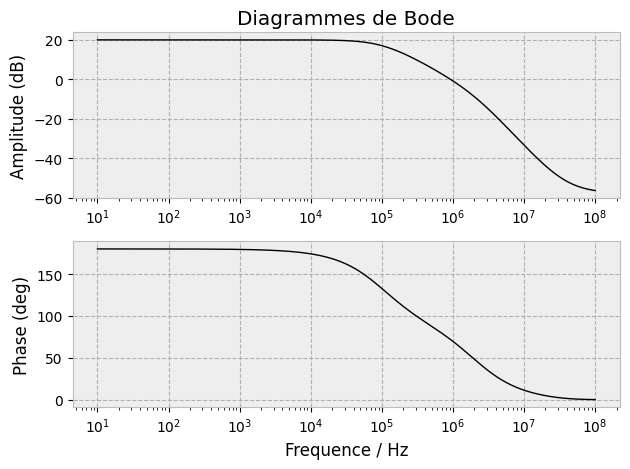

In [31]:
plt.subplot(211)
plt.title('Diagrammes de Bode')
plt.semilogx(freq, 20*np.log10(gain2), lw=1, c="black")    # Amplitude
plt.ylabel('Amplitude (dB)')


plt.subplot(212)
plt.semilogx(freq, phase2, c="black", lw=1)  # Phase
plt.xlabel('Frequence / Hz')
plt.ylabel('Phase (deg)')


plt.tight_layout()  # Ajuster le placement des courbes
plt.show()

### Conclusion

We can see that the two methods do not produce exactly the same results.  
This difference arises because the second method provides a **more accurate** and **faster** solution.

Moreover, it is evident that starting from **100 kHz**, the output signal becomes significantly attenuated.  
At **100 MHz**, the amplifier is **no longer able to follow the input signal**, making it practically ineffective.

## Characteristics

The objective of this section is to **characterize the amplifier**.
We aim to determine three key aspects:

1. The **matrix relationship** between input and output voltages and currents.
2. The **frequency response** (or bandwidth) of the amplifier.
3. The **linearity** of the output signal.

## Matrix Relationship

The first step is to establish a **matrix relation** linking the **input and output electrical quantities** — namely, the voltages and currents.

For a **voltage amplifier**, these quantities are described by **four fundamental parameters**:

* **$Z_e$** – input impedance
* **$Z_s$** – output impedance
* **$G$** – transconductance (gain relating input current to output voltage)
* **$G_{12}$** – reverse transfer parameter (feedback or reverse gain)

The general matrix relationship can be written as:

$$
\begin{pmatrix}
V_1\\[4pt]
V_2
\end{pmatrix} =
\begin{pmatrix}
Z_e & G_{12}\\[4pt]
G & Z_s
\end{pmatrix}
\begin{pmatrix}
I_1\\[4pt]
I_2
\end{pmatrix}
$$


```{figure} ./images/Amplifier_quadripole.svg
:name: Quadripole_simple_inverting_amplifier
:align: center
:width: 500px

Simplified quadripole model of an amplifier
```

This **two-port (quadripole) representation** is widely used to describe amplifiers in a **linear, small-signal regime**.
It provides a compact and analytical way to relate the **input and output characteristics**, which are later used to analyze **gain**, **impedance matching**, and **feedback effects**.

In [41]:
# coming soon

### Bandwidth

The goal is to determine the **bandwidth** of the amplifier, defined as the frequency range over which the signal drops by **3 dB** from its maximum value.

```{figure} ./images/Amplifier_bandwidth.svg
:name: amplifier_bandwidth_inverting_amplifier
:align: center
:width: 500px

Amplifier frequency response (bandwidth)
```

In [32]:
# Initialisation variable
amplitude = 1.7

circuit = Circuit('Inverting op-amp Amplifier')
circuit.include('lib/UA741.sub')

# Alimentation AOP
circuit.SinusoidalVoltageSource('input', 'input', circuit.gnd, amplitude=amplitude@u_V, frequency=1@u_Hz)
circuit.V('cc', 'VCC', circuit.gnd, 15@u_V)
circuit.V('ee', 'VEE', circuit.gnd, -15@u_V)

circuit.subcircuit(AOP_montage())
circuit.X('AMP1', 'AOP_inverting_amplifier', 'input', 'v-', 'out', 'VCC', 'VEE')

.title Inverting op-amp Amplifier
.include C:\Users\sacha\Desktop\Python\Electronique\electronique_book\AOP\lib\UA741.sub
.subckt AOP_inverting_amplifier input v- out VCC VEE
XU1 0 v- VCC VEE out UA741
R1 input v- 10kOhm
R2 v- out 100kOhm
RL out 0 10kOhm
.ends AOP_inverting_amplifier
Vinput input 0 DC 0V AC 1V SIN(0V 1.7V 1Hz 0s 0Hz)
Vcc VCC 0 15V
Vee VEE 0 -15V
XAMP1 input v- out VCC VEE AOP_inverting_amplifier



In [33]:
# Simulation AC
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.ac(start_frequency=10@u_Hz, stop_frequency=100@u_MHz, number_of_points=1000, variation='dec')

In [34]:
freq   = np.array(analysis.frequency)
gain2  = np.abs(np.array(analysis['out'])) / np.abs(np.array(analysis['input']))
phase2 = np.angle(np.array(analysis['out']), True) - np.angle(np.array(analysis['input']), True)
bande_passante = max(20*np.log10(np.abs(analysis['out']))) - 3

Should be unit less


Should be unit less


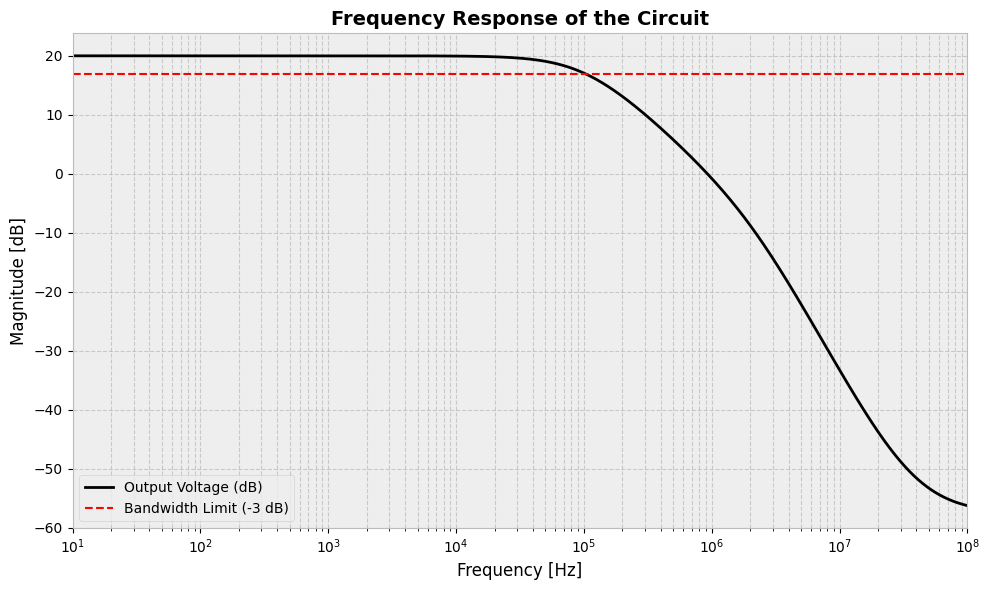

In [35]:
# ---------------------------------------------------------
# Frequency Response (Bode Plot)
# ---------------------------------------------------------

plt.figure(figsize=(10, 6))

# Plot magnitude response in dB
plt.semilogx(freq, 20 * np.log10(np.abs(analysis['out'])), color='black', linewidth=2, label='Output Voltage (dB)')

# Reference line for the -3 dB cutoff (bandwidth)
plt.axhline(y=bande_passante, color='red', linestyle='--', linewidth=1.5, label='Bandwidth Limit (-3 dB)')

# Axis formatting
plt.xlim(10, 1e8)
#plt.ylim(-60, 10)
plt.grid(True, which='both', linestyle='--', alpha=0.6)

# Titles and labels
plt.title('Frequency Response of the Circuit', fontsize=14, weight='bold')
plt.xlabel('Frequency [Hz]', fontsize=12)
plt.ylabel('Magnitude [dB]', fontsize=12)

# Legend
plt.legend(loc='best', fontsize=10, frameon=True)

# Layout optimization
plt.tight_layout()
plt.show()

```{danger}
Note: In Python, `np.log()` calculates the **natural logarithm (ln)**, not log base 10.  
- For **log base 10**, use `np.log10()`.  
- For **log base 2**, use `np.log2()`.
```

### System Linearity

Next, we analyze the **linearity** of the amplifier. This directly relates to the **Saturation Simulation** chapter.

For an ideal amplifier, the input–output relationship should look like this:

```{figure} ./images/Linearity_and_saturation.svg
:name: amplifier_linearity_inversing_amplifier
:align: center
:width: 500px

Amplifier linearity and saturation
```

In [36]:
circuit = Circuit('Inverting op-amp Amplifier')
circuit.include('lib/UA741.sub')

# Alimentation AOP
circuit.V('in', 'input', circuit.gnd, 1@u_V)
circuit.V('cc', 'VCC', circuit.gnd, 15@u_V)
circuit.V('ee', 'VEE', circuit.gnd, -15@u_V)

circuit.subcircuit(AOP_montage())
circuit.X('AMP1', 'AOP_inverting_amplifier', 'input', 'v-', 'out', 'VCC', 'VEE')

.title Inverting op-amp Amplifier
.include C:\Users\sacha\Desktop\Python\Electronique\electronique_book\AOP\lib\UA741.sub
.subckt AOP_inverting_amplifier input v- out VCC VEE
XU1 0 v- VCC VEE out UA741
R1 input v- 10kOhm
R2 v- out 100kOhm
RL out 0 10kOhm
.ends AOP_inverting_amplifier
Vin input 0 1V
Vcc VCC 0 15V
Vee VEE 0 -15V
XAMP1 input v- out VCC VEE AOP_inverting_amplifier



In [37]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.operating_point()

In [38]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.dc(Vin=slice(-5, 5, 0.02))

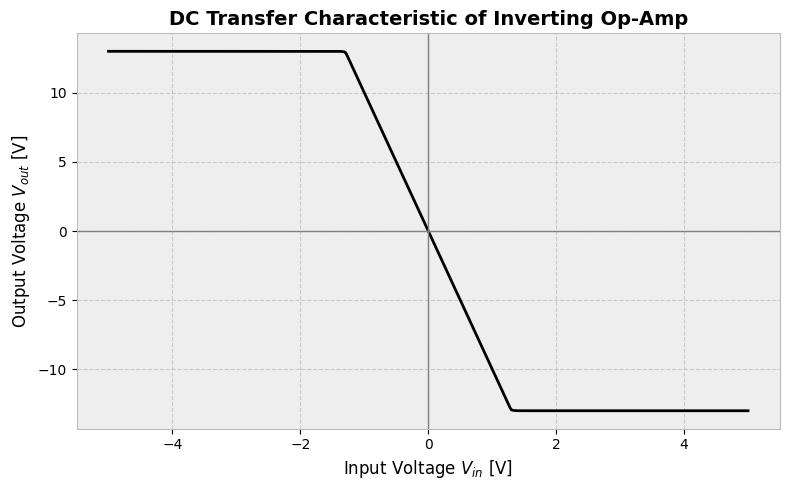

In [39]:
# Extract data
Vin_values = np.array(analysis.sweep)       # Input voltage sweep
Vout_values = np.array(analysis.out)        # Output voltage

# Plot
plt.figure(figsize=(8, 5))
plt.plot(Vin_values, Vout_values, color='black', linewidth=2)

# Graph formatting
plt.title('DC Transfer Characteristic of Inverting Op-Amp', fontsize=14, weight='bold')
plt.xlabel('Input Voltage $V_{in}$ [V]', fontsize=12)
plt.ylabel('Output Voltage $V_{out}$ [V]', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.tight_layout()
plt.show()

To visualize this, we gradually increase the **input voltage** and observe the system response.

**Observations from the graph:**

1. The output **saturates** at approximately ±15 V, consistent with previous studies.
2. The slope is **negative**, confirming that the amplifier has a **negative gain**.

### Distortion

In this study, **signal distortion** has not been analyzed in detail.
Future work could include measuring **harmonic distortion (THD)** or other non-linear effects to better characterize the amplifier.